In [1]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Conv2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K
import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio
import sys
import csv

Using TensorFlow backend.


In [2]:
def patch_diff(patch1, patch2):
    """Computing the sum of squared differences (SSD) between two images."""
    if patch1.shape != patch2.shape:
        print("Images don't have the same shape.")
        return
    return np.sum((np.array(patch1, dtype=np.float32) - np.array(patch2, dtype=np.float32))**2)

In [3]:
# image_path = '/home/niaki/Downloads/barbara.jpg'
# image_path = '/home/niaki/Downloads/house.tiff'
# image_path = '/home/niaki/Downloads/monarch.png'
image_path = '/home/niaki/Downloads/Lenna.png'


patch_size = 16
patch_width = patch_size
patch_height = patch_size

nearest_patches_nb = -1
query_stride = 100
compare_stride = 8
eps = 0.0001

nr_similar_patches = 40

In [4]:
image = imageio.imread(image_path)

# to be deleted
# image = image[:40, :40, :]

image_height = image.shape[0]
image_width = image.shape[1]

if nearest_patches_nb == -1:
    nearest_patches_nb = len(range(0, image_width - patch_size + 1, compare_stride)) * len(range(0, image_height - patch_size + 1, compare_stride))

In [5]:
# clean image

query_x_coords = []
query_y_coords = []

results_patches_diffs = {}
results_patches_x_coords = {}
results_patches_y_coords = {}
results_patches_positions = {}

counter_query_patches = 0

# just for the sake of output
total_nr_query_patches = len(range(0, image_width - patch_size + 1, query_stride)) * len(range(0, image_height - patch_size + 1, query_stride))

for y_query in range(0, image_width - patch_size + 1, query_stride):
    for x_query in range(0, image_height - patch_size + 1, query_stride):
        sys.stdout.write("\r" + str(counter_query_patches + 1) + "/" + str(total_nr_query_patches))
        
        query_x_coords.append(x_query)
        query_y_coords.append(y_query)        
    
        query_patch = image[x_query : x_query + patch_size, y_query : y_query + patch_size, :]
        
        counter_compare_patches = 0
        compare_patches_scores = {}
        
        patches_diffs = [1000000000]
        patches_x_coords = [-1]
        patches_y_coords = [-1]
        patches_positions = [-1]
        
        for y_compare in range(0, image_width - patch_size + 1, compare_stride):
            for x_compare in range(0, image_height - patch_size + 1, compare_stride):
                
                compare_patch = image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :]
                diff = patch_diff(query_patch, compare_patch)
                
                if diff < eps:
                    counter_compare_patches += 1
                    continue
                
                # sorting
                for i in range(len(patches_diffs)):
                    if diff < patches_diffs[i]:
                        patches_diffs.insert(i, diff)
                        patches_x_coords.insert(i, x_compare)
                        patches_y_coords.insert(i, y_compare)
                        patches_positions.insert(i, counter_compare_patches)
                        break
                
                counter_compare_patches += 1
                
        results_patches_diffs[counter_query_patches] = patches_diffs[:nearest_patches_nb]
        results_patches_x_coords[counter_query_patches] = patches_x_coords[:nearest_patches_nb]
        results_patches_y_coords[counter_query_patches] = patches_y_coords[:nearest_patches_nb]
        results_patches_positions[counter_query_patches] = patches_positions[:nearest_patches_nb]
        
        counter_query_patches += 1

25/25

In [6]:
image_noisy = image

In [24]:
base_dir = '/home/niaki/Code/ImageNet/tiny-imagenet-200'
model_version = '16_3conv3mp_2.7' #'16_3conv3mp_2.7
encoder = load_model(base_dir + '/encoder' + model_version + '.h5')


query_x_coords = []
query_y_coords = []

results_noisy_descr_patches_diffs = {}
results_noisy_descr_patches_x_coords = {}
results_noisy_descr_patches_y_coords = {}
results_noisy_descr_patches_positions = {}

counter_query_patches = 0

# just for the sake of output
total_nr_query_patches = len(range(0, image_width - patch_size + 1, query_stride)) * len(range(0, image_height - patch_size + 1, query_stride))

for y_query in range(0, image_width - patch_size + 1, query_stride):
    for x_query in range(0, image_height - patch_size + 1, query_stride):
        sys.stdout.write("\r" + str(counter_query_patches + 1) + "/" + str(total_nr_query_patches))
        
        query_x_coords.append(x_query)
        query_y_coords.append(y_query)   

        query_patch = image_noisy[x_query : x_query + patch_size, y_query : y_query + patch_size, :]
        query_patch_descr = encoder.predict(np.expand_dims(query_patch, axis=0))[0]
#         query_patch_descr = np.mean(query_patch)

        counter_compare_patches = 0
        compare_patches_scores = {}

        patches_diffs = [1000000000]
        patches_x_coords = [-1]
        patches_y_coords = [-1]
        patches_positions = [-1]

        for y_compare in range(0, image_width - patch_size + 1, compare_stride):
            for x_compare in range(0, image_height - patch_size + 1, compare_stride):

                compare_patch = image_noisy[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :]
                compare_patch_descr = encoder.predict(np.expand_dims(compare_patch, axis=0))[0]
#                 compare_patch_descr = np.mean(compare_patch)

                diff = patch_diff(query_patch_descr, compare_patch_descr)
#                 diff = (query_patch_descr - compare_patch_descr)**2

                if diff < eps:
                    counter_compare_patches += 1
                    continue

                # sorting
                for i in range(len(patches_diffs)):
                    if diff < patches_diffs[i]:
                        patches_diffs.insert(i, diff)
                        patches_x_coords.insert(i, x_compare)
                        patches_y_coords.insert(i, y_compare)
                        patches_positions.insert(i, counter_compare_patches)
                        break

                counter_compare_patches += 1

        results_noisy_descr_patches_diffs[counter_query_patches] = patches_diffs[:nearest_patches_nb]
        results_noisy_descr_patches_x_coords[counter_query_patches] = patches_x_coords[:nearest_patches_nb]
        results_noisy_descr_patches_y_coords[counter_query_patches] = patches_y_coords[:nearest_patches_nb]
        results_noisy_descr_patches_positions[counter_query_patches] = patches_positions[:nearest_patches_nb]

        counter_query_patches += 1

25/25

In [8]:
theta = np.load('/home/niaki/temp/encoderChenEtAl_RGB_400it.npy')

input_size = 16 * 16 *3
hidden_size = 128

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

W1 = theta[0:hidden_size * input_size].reshape(hidden_size, input_size)
W2 = theta[hidden_size * input_size:2 * hidden_size * input_size].reshape(input_size, hidden_size)
b1 = theta[2 * hidden_size * input_size:2 * hidden_size * input_size + hidden_size]
b2 = theta[2 * hidden_size * input_size + hidden_size:]

query_x_coords = []
query_y_coords = []

results_noisy_descr_patches_diffs = {}
results_noisy_descr_patches_x_coords = {}
results_noisy_descr_patches_y_coords = {}
results_noisy_descr_patches_positions = {}

counter_query_patches = 0

# just for the sake of output
total_nr_query_patches = len(range(0, image_width - patch_size + 1, query_stride)) * len(range(0, image_height - patch_size + 1, query_stride))

for y_query in range(0, image_width - patch_size + 1, query_stride):
    for x_query in range(0, image_height - patch_size + 1, query_stride):
#             sys.stdout.write("\r" + str(counter_query_patches + 1) + "/" + str(total_nr_query_patches))

        query_x_coords.append(x_query)
        query_y_coords.append(y_query)   

        query_patch = image_noisy[x_query : x_query + patch_size, y_query : y_query + patch_size, :]
#             query_patch_descr = encoder.predict(np.expand_dims(query_patch, axis=0))[0]
#         query_patch_descr = np.mean(query_patch)
        data = np.expand_dims(query_patch.reshape(patch_size * patch_size * 3), axis=1)
        z2 = W1.dot(data) + np.tile(b1, (1, 1)).transpose()
        query_patch_descr = sigmoid(z2)


        counter_compare_patches = 0
        compare_patches_scores = {}

        patches_diffs = [1000000000]
        patches_x_coords = [-1]
        patches_y_coords = [-1]
        patches_positions = [-1]

        for y_compare in range(0, image_width - patch_size + 1, compare_stride):
            for x_compare in range(0, image_height - patch_size + 1, compare_stride):

                compare_patch = image_noisy[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :]
#                     compare_patch_descr = encoder.predict(np.expand_dims(compare_patch, axis=0))[0]
#                 compare_patch_descr = np.mean(compare_patch)
                data = np.expand_dims(compare_patch.reshape(patch_size * patch_size * 3), axis=1)
                z2 = W1.dot(data) + np.tile(b1, (1, 1)).transpose()
                compare_patch_descr = sigmoid(z2)    

                diff = patch_diff(query_patch_descr, compare_patch_descr)
#                 diff = (query_patch_descr - compare_patch_descr)**2

                if diff < eps:
                    counter_compare_patches += 1
                    continue

                # sorting
                for i in range(len(patches_diffs)):
                    if diff < patches_diffs[i]:
                        patches_diffs.insert(i, diff)
                        patches_x_coords.insert(i, x_compare)
                        patches_y_coords.insert(i, y_compare)
                        patches_positions.insert(i, counter_compare_patches)
                        break

                counter_compare_patches += 1

        results_noisy_descr_patches_diffs[counter_query_patches] = patches_diffs[:nearest_patches_nb]
        results_noisy_descr_patches_x_coords[counter_query_patches] = patches_x_coords[:nearest_patches_nb]
        results_noisy_descr_patches_y_coords[counter_query_patches] = patches_y_coords[:nearest_patches_nb]
        results_noisy_descr_patches_positions[counter_query_patches] = patches_positions[:nearest_patches_nb]

        counter_query_patches += 1



/scratch/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [31]:
ssds = []

nr_similar_patches = 5

for q_it in range(total_nr_query_patches):
    for c_it in range(nr_similar_patches):
        
        # getting the query patch from the clean image
        x_query = query_x_coords[q_it]
        y_query = query_y_coords[q_it]
        query_patch = image[x_query : x_query + patch_size, y_query : y_query + patch_size, :]
        
        # getting the compare patch from the clean image
        x_compare = results_noisy_descr_patches_x_coords[q_it][c_it]
        y_compare = results_noisy_descr_patches_y_coords[q_it][c_it]
        compare_patch = image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :]
        
        # calculating the difference in the clean image
        actual_diff = patch_diff(query_patch, compare_patch)
        ssds.append(actual_diff)
        
ssds = np.array(ssds)

/scratch/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


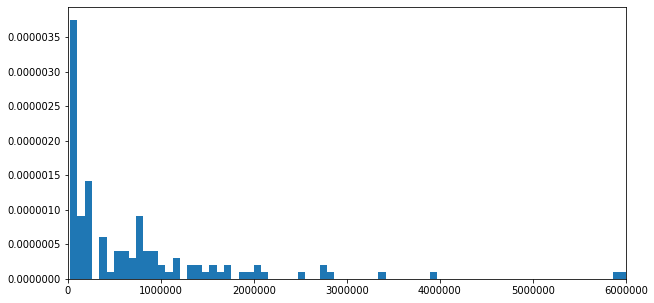

In [26]:
plt.figure(figsize=(10, 5))
plt.hist(ssds, 100, normed=1)
plt.xlim(0, 6000000)
plt.show()

/scratch/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


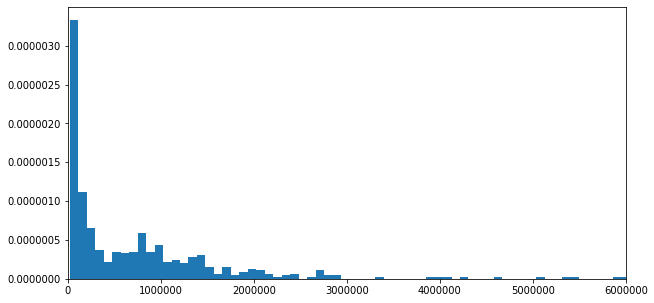

In [29]:
plt.figure(figsize=(10, 5))
plt.hist(ssds, 100, normed=1)
plt.xlim(0, 6000000)
plt.show()

/scratch/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


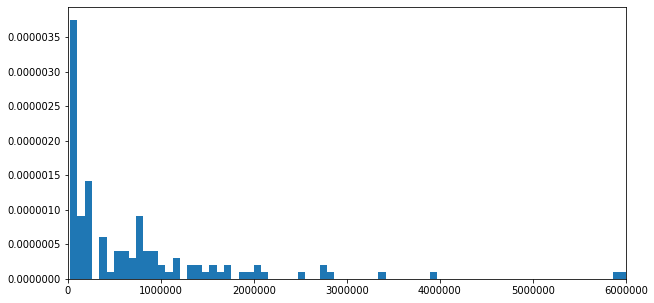

In [32]:
plt.figure(figsize=(10, 5))
plt.hist(ssds, 100, normed=1)
plt.xlim(0, 6000000)
plt.show()

/scratch/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


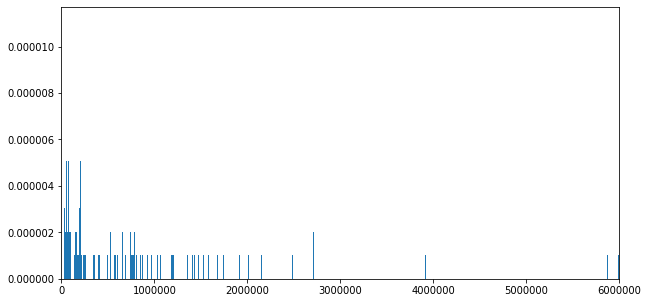

In [27]:
plt.figure(figsize=(10, 5))
plt.hist(ssds, 1000, normed=1)
plt.xlim(0, 6000000)
plt.show()

/scratch/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


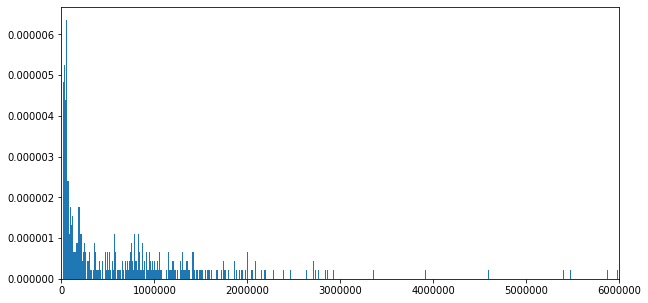

In [30]:
plt.figure(figsize=(10, 5))
plt.hist(ssds, 1000, normed=1)
plt.xlim(0, 6000000)
plt.show()

/scratch/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


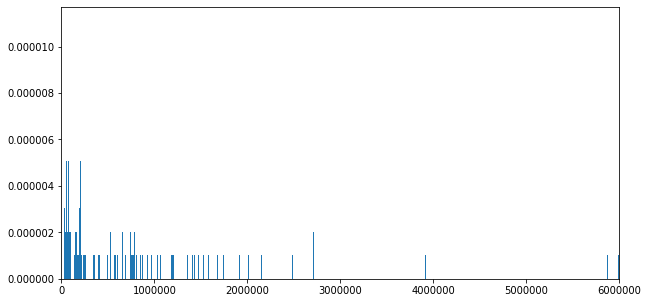

In [33]:
plt.figure(figsize=(10, 5))
plt.hist(ssds, 1000, normed=1)
plt.xlim(0, 6000000)
plt.show()

/scratch/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


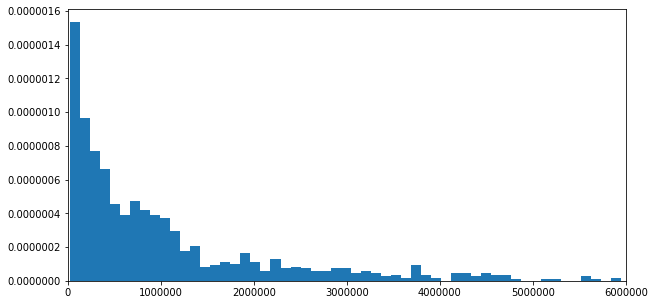

In [14]:
plt.figure(figsize=(10, 5))
plt.hist(ssds, 100, normed=1)
plt.xlim(0, 6000000)
plt.show()

/scratch/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


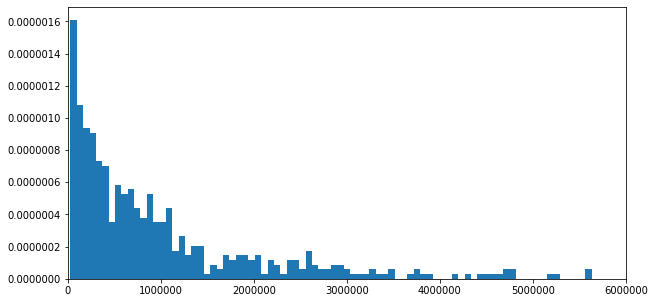

In [17]:
plt.figure(figsize=(10, 5))
plt.hist(ssds, 100, normed=1)
plt.xlim(0, 6000000)
plt.show()

/scratch/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


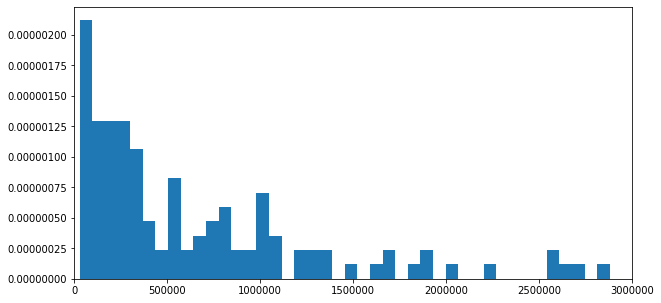

In [22]:
plt.figure(figsize=(10, 5))
plt.hist(ssds, 100, normed=1)
plt.xlim(0, 3000000)
plt.show()

/scratch/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


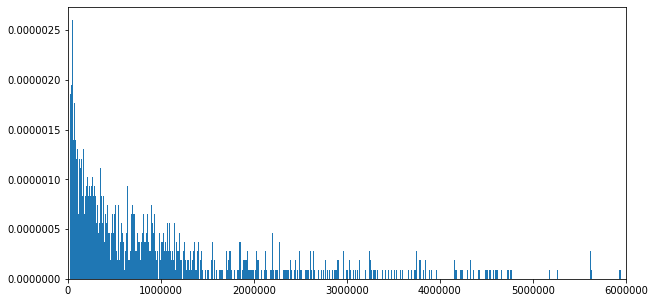

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(ssds, 1000, normed=1)
plt.xlim(0, 6000000)
plt.show()

/scratch/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


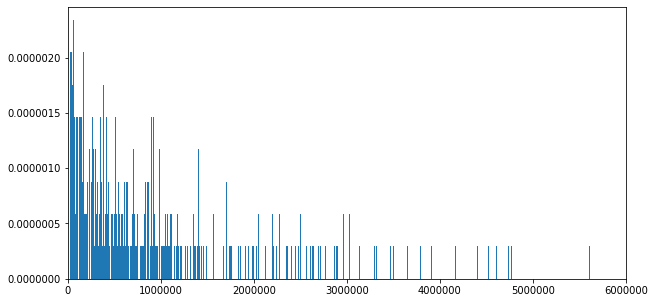

In [16]:
plt.figure(figsize=(10, 5))
plt.hist(ssds, 1000, normed=1)
plt.xlim(0, 6000000)
plt.show()

/scratch/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


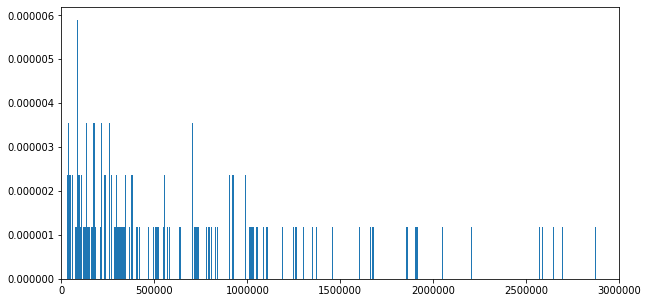

In [23]:
plt.figure(figsize=(10, 5))
plt.hist(ssds, 1000, normed=1)
plt.xlim(0, 3000000)
plt.show()